# Pylint and Radon on all Code Blocks

In [17]:
import sqlite3
import pandas as pd
import os

db_path = "../../giicg.db"
if not os.path.exists(db_path):
    raise FileNotFoundError(f"Database file does not exist: {db_path}")

conn = sqlite3.connect(db_path)
query = """
SELECT
    c.*,
    m.conversation_id, m.message_id,
    u.user_id, u.gender, u.work_exp_years, u.age,
    conv.llm_version, conv.satisfaction, conv.rated_complexity
FROM code_blocks c
JOIN messages m ON c.message_id = m.message_id
JOIN conversations conv ON m.conversation_id = conv.conversation_id
JOIN users u ON conv.user_id = u.user_id
"""

code_blocks = pd.read_sql(query, conn)

code_blocks = code_blocks.dropna(subset=['code_text'])
code_blocks = code_blocks[code_blocks['code_text'].str.strip() != '']
code_blocks = code_blocks.dropna(subset=['code_text'])
code_blocks = code_blocks[(code_blocks['gender'] == 'Woman (cisgender)') | (code_blocks['gender'] == 'Man (cisgender)')]
code_blocks = code_blocks[(code_blocks['language'] == 'python')]
code_blocks = code_blocks.drop_duplicates(subset=['code_text'])
code_blocks = code_blocks.loc[:, ~code_blocks.columns.duplicated()]


code_blocks

,code_block_id,message_id,code_text,language,conversation_id,user_id,gender,work_exp_years,age,llm_version,satisfaction,rated_complexity
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,16,Woman (cisgender),None,19-25,None,very satisfied,relatively simple
5,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,16,Woman (cisgender),None,19-25,None,very satisfied,relatively simple
...,...,...,...,...,...,...,...,...,...,...,...,...
1693,1694,1750,\n # Plotte Daten für beide...,python,29,90,Woman (cisgender),2.0,26-30,ChatGPT,neutral,relatively simple
1694,1695,1752,\n import cv2\n import i...,python,19,63,Woman (cisgender),2.0,26-30,"ChatGPT-4o,",very satisfied,relatively simple
1695,1696,1754,\n import cv2\n\n def ex...,python,19,63,Woman (cisgender),2.0,26-30,"ChatGPT-4o,",very satisfied,relatively simple
1737,1738,1844,\n # Step 1: Load and Visua...,python,2,8,Man (cisgender),1.0,19-25,ChatGPT-4o-mini-high,somewhat satisfied,relatively complex


In [18]:
num_code_blocks = code_blocks.groupby('user_id').count().reset_index()
num_code_blocks

,user_id,code_block_id,message_id,code_text,language,conversation_id,gender,work_exp_years,age,llm_version,satisfaction,rated_complexity
0,6,16,16,16,16,16,16,16,16,0,16,16
1,8,2,2,2,2,2,2,2,2,2,2,2
2,11,18,18,18,18,18,18,18,18,0,18,18
3,16,35,35,35,35,35,35,0,35,0,35,35
4,28,43,43,43,43,43,43,43,43,43,43,43
5,31,1,1,1,1,1,1,1,1,1,1,1
6,34,72,72,72,72,72,72,72,72,72,72,72
7,46,8,8,8,8,8,8,8,8,8,8,8
8,48,10,10,10,10,10,10,0,10,10,10,10
9,55,69,69,69,69,69,69,69,69,69,69,69


## Subsample from user 73

In [19]:
def subsample_code_blocks(df, user_id, n=50):
    """Subsample up to n code blocks from the specified user, keep all others."""
    # Separate the code blocks for the target user
    user_blocks = df[df['user_id'] == user_id]
    other_blocks = df[df['user_id'] != user_id]

    # Subsample n code blocks for the target user (if < n rows, use all)
    sample_n = min(n, len(user_blocks))
    user_blocks_sampled = user_blocks.sample(n=sample_n, random_state=42)

    # Combine with the original code blocks from other users
    combined = pd.concat([other_blocks, user_blocks_sampled], ignore_index=True)

    # Summarize number of code blocks per user
    summary_per_user = combined.groupby('user_id')['code_text'].nunique().reset_index(name='num_code_blocks')
    user_gender = combined[['user_id', 'gender']].drop_duplicates()
    summary_with_gender = summary_per_user.merge(user_gender, on='user_id', how='left')
    print(summary_with_gender.groupby('gender').sum(numeric_only=True))

    # Number of users per gender in the new subset
    users_per_gender = combined.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
    print(users_per_gender)

    return combined

# Example usage:
code_blocks = subsample_code_blocks(code_blocks, user_id=73, n=50)
code_blocks


                   user_id  num_code_blocks
gender                                     
Man (cisgender)        610              152
Woman (cisgender)      677              352
              gender  num_users
0    Man (cisgender)         11
1  Woman (cisgender)         12


,code_block_id,message_id,code_text,language,conversation_id,user_id,gender,work_exp_years,age,llm_version,satisfaction,rated_complexity
0,1,2,rdd = sc.parallelize(iter(range(10)))\nprint(r...,python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
1,2,2,iterator = iter(range(10))\ndf = spark.createD...,python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
2,3,2,"from pyspark.sql.types import IntegerType, Str...",python,1,6,Man (cisgender),3.0,19-25,None,neutral,neither complex nor simple
3,4,6,import pandas as pd\nfrom sklearn.preprocessin...,python,6,16,Woman (cisgender),None,19-25,None,very satisfied,relatively simple
4,6,8,import pandas as pd\n\n# Sample DataFrame\ndat...,python,6,16,Woman (cisgender),None,19-25,None,very satisfied,relatively simple
...,...,...,...,...,...,...,...,...,...,...,...,...
499,1331,1377,results_df = grid_search_optics_with_pca_and_c...,python,65,73,Woman (cisgender),None,31-35,ChatGPT-4o,very satisfied,neither complex nor simple
500,1182,1289,from sklearn.manifold import TSNE\nimport matp...,python,65,73,Woman (cisgender),None,31-35,ChatGPT-4o,very satisfied,neither complex nor simple
501,247,347,criterion = torch.nn.CrossEntropyLoss(label_sm...,python,21,73,Woman (cisgender),None,31-35,ChatGPT-4o,very satisfied,very complex
502,496,483,from sklearn.metrics import balanced_accuracy_...,python,21,73,Woman (cisgender),None,31-35,ChatGPT-4o,very satisfied,very complex


In [20]:
num_code_blocks_after_subsampling = code_blocks.groupby('user_id').count().reset_index()
num_code_blocks_after_subsampling

,user_id,code_block_id,message_id,code_text,language,conversation_id,gender,work_exp_years,age,llm_version,satisfaction,rated_complexity
0,6,16,16,16,16,16,16,16,16,0,16,16
1,8,2,2,2,2,2,2,2,2,2,2,2
2,11,18,18,18,18,18,18,18,18,0,18,18
3,16,35,35,35,35,35,35,0,35,0,35,35
4,28,43,43,43,43,43,43,43,43,43,43,43
5,31,1,1,1,1,1,1,1,1,1,1,1
6,34,72,72,72,72,72,72,72,72,72,72,72
7,46,8,8,8,8,8,8,8,8,8,8,8
8,48,10,10,10,10,10,10,0,10,10,10,10
9,55,69,69,69,69,69,69,69,69,69,69,69


In [21]:
from helpers.pylint_radon import calc_radon_metrics, run_pylint_on_code

print("Running radon analysis on all code blocks...")
metrics = code_blocks['code_text'].apply(calc_radon_metrics)
columns = ['radon_complexity', 'radon_maintainability_index',
           'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments']
for idx, col in enumerate(columns):
    code_blocks[col] = metrics.apply(lambda vals: vals[idx])

# filtering out short code blocks for pylint
code_blocks = code_blocks[code_blocks['radon_sloc'] >= 10]

print("Running pylint on all code blocks...")
code_blocks['pylint_score'], code_blocks['pylint_messages'], code_blocks['pylint_codes'] = zip(*code_blocks.apply(lambda row: run_pylint_on_code(row['code_text']), axis=1))

code_blocks

Running radon analysis on all code blocks...
Running pylint on all code blocks...


/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/841552478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code_blocks['pylint_score'], code_blocks['pylint_messages'], code_blocks['pylint_codes'] = zip(*code_blocks.apply(lambda row: run_pylint_on_code(row['code_text']), axis=1))
/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/841552478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code_blocks['pylint_score'], code_blocks['pylint_messages'], code_blocks['pylint_code

,code_block_id,message_id,code_text,language,conversation_id,user_id,gender,work_exp_years,age,llm_version,...,rated_complexity,radon_complexity,radon_maintainability_index,radon_loc,radon_sloc,radon_lloc,radon_comments,pylint_score,pylint_messages,pylint_codes
9,13,16,import pandas as pd\nfrom sklearn.preprocessin...,python,6,16,Woman (cisgender),None,19-25,None,...,relatively simple,0.000000,100.000000,22.0,10.0,11.0,6.0,9.00,************* Module tmpi4nhcnaq\n/var/folders...,[C0301]
10,15,18,import pandas as pd\nfrom sklearn.preprocessin...,python,6,16,Woman (cisgender),None,19-25,None,...,relatively simple,0.000000,100.000000,22.0,10.0,11.0,6.0,9.00,************* Module tmpgdbwbbil\n/var/folders...,[C0301]
11,17,20,import pandas as pd\n\n# Sample DataFrame (ass...,python,6,16,Woman (cisgender),None,19-25,None,...,relatively simple,0.000000,100.000000,17.0,10.0,6.0,3.0,10.00,------------------------------------\nYour cod...,[]
18,24,26,import numpy as np\n\n# Step 1: Identify women...,python,6,16,Woman (cisgender),None,19-25,None,...,relatively simple,0.000000,96.308006,18.0,10.0,6.0,4.0,6.00,************* Module tmpkzeww74d\n/var/folders...,"[C0301, W0611]"
19,25,28,import pandas as pd\nimport numpy as np\n\n# S...,python,6,16,Woman (cisgender),None,19-25,None,...,relatively simple,0.000000,87.406740,45.0,30.0,13.0,8.0,10.00,------------------------------------\nYour cod...,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
488,1349,1395,import pandas as pd\nimport numpy as np\nfrom ...,python,65,73,Woman (cisgender),None,31-35,ChatGPT-4o,...,neither complex nor simple,12.000000,72.842727,84.0,50.0,48.0,11.0,7.73,************* Module tmptoff9uap\n/var/folders...,"[C0301, C0301, C0301, C0301, C0301, R0914, W07..."
489,220,327,import torchvision\nimport torch\nimport torch...,python,21,73,Woman (cisgender),None,31-35,ChatGPT-4o,...,very complex,2.000000,71.586334,83.0,58.0,52.0,13.0,7.80,************* Module tmpywhglv3r\n/var/folders...,"[C0301, C0301, C0301, R0402, R0402, R0402, C01..."
495,1634,1685,import numpy as np\nfrom sklearn.cluster impor...,python,87,73,Woman (cisgender),None,31-35,ChatGPT-4o,...,neither complex nor simple,2.538462,40.144219,241.0,187.0,179.0,11.0,7.16,************* Module tmp4et3x5ws\n/var/folders...,"[C0301, C0301, C0301, C0301, C0301, C0301, C03..."
497,505,487,predictor = MultiModalPredictor(\n problem_...,python,21,73,Woman (cisgender),None,31-35,ChatGPT-4o,...,very complex,0.000000,100.000000,10.0,10.0,2.0,4.0,10.00,------------------------------------\nYour cod...,[]


In [22]:
from sklearn.preprocessing import MultiLabelBinarizer

#one hot encoding for pylint scores
mlb = MultiLabelBinarizer()
binarized = pd.DataFrame(mlb.fit_transform(code_blocks['pylint_codes']),
                       columns=mlb.classes_,
                       index=code_blocks.index)
concatenated = pd.concat([code_blocks, binarized], axis=1)
cleaned = concatenated.drop(columns=['pylint_codes'])

code_blocks = cleaned

code_blocks.to_sql("all_code_block_with_scores", conn, if_exists="replace", index=False)

236

## Analyze Scores


In [23]:
users_per_gender = code_blocks.groupby('gender')['user_id'].nunique().reset_index(name='num_users')
users_per_gender

,gender,num_users
0,Man (cisgender),9
1,Woman (cisgender),12


In [24]:
code_blocks_per_user = code_blocks.groupby(['user_id', 'gender'])['code_text'].nunique().reset_index(name='num_blocks')
code_blocks_per_user

,user_id,gender,num_blocks
0,6,Man (cisgender),2
1,8,Man (cisgender),2
2,11,Woman (cisgender),8
3,16,Woman (cisgender),10
4,28,Woman (cisgender),9
5,34,Man (cisgender),56
6,46,Man (cisgender),8
7,48,Woman (cisgender),3
8,55,Woman (cisgender),34
9,56,Man (cisgender),5


## T-test

In [28]:
from statsmodels.stats.multitest import multipletests
from helpers.statistical_tests import compare_genders

print("Average pylint score (Female):", code_blocks[code_blocks['gender'] == 'Woman (cisgender)']['pylint_score'].mean())
print("Average pylint score (Male):", code_blocks[code_blocks['gender'] == 'Man (cisgender)']['pylint_score'].mean())


def groupwise_comparison_with_correction(df, columns):
    p_vals = []
    test_types = []
    female_vars = []
    male_vars = []
    nonzero_females = []
    nonzero_males = []
    for col in columns:
        p_value, test_type, female_var, male_var, nonzero_female, nonzero_male = compare_genders(df, col)
        p_vals.append(p_value)
        test_types.append(test_type)
        female_vars.append(female_var)
        male_vars.append(male_var)
        nonzero_females.append(nonzero_female)
        nonzero_males.append(nonzero_male)
    reject, pvals_corrected, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')

    results = pd.DataFrame({
        'metric': columns,
        'test type': test_types,
        'p_value': p_vals,
        'corrected p_value': pvals_corrected,
        'f_var': female_vars,
        'm_var': male_vars,
        'n_hits': [{'female': f, 'male': m} for f, m in zip(nonzero_females, nonzero_males)]
    })
    return results


Average pylint score (Female): 8.055112781954888
Average pylint score (Male): 7.812584269662921


/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:54: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_female, p_female = stats.shapiro(female)
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:47: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p_value = stats.mannwhitneyu(male, female, alternative='two-sided')
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_male, p_male = stats.shapiro(male)
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:47: SmallSampleWarning: One or more sample arguments is too small; all returned values wil

,metric,test type,p_value,corrected p_value,f_var,m_var,n_hits,llm_version
0,pylint_score,U-test,NaN,NaN,NaN,0.875062,"{'female': 0, 'male': 7}",ChatGPT-4o
1,radon_complexity,U-test,NaN,NaN,NaN,6.654762,"{'female': 0, 'male': 6}",ChatGPT-4o
2,radon_maintainability_index,U-test,NaN,NaN,NaN,105.861409,"{'female': 0, 'male': 7}",ChatGPT-4o
3,radon_loc,U-test,NaN,NaN,NaN,178.285714,"{'female': 0, 'male': 7}",ChatGPT-4o
4,radon_sloc,U-test,NaN,NaN,NaN,81.142857,"{'female': 0, 'male': 7}",ChatGPT-4o
...,...,...,...,...,...,...,...,...
121,radon_maintainability_index,U-test,NaN,NaN,148.685035,NaN,"{'female': 10, 'male': 0}",gpt-4o-mini
122,radon_loc,U-test,NaN,NaN,444.222222,NaN,"{'female': 10, 'male': 0}",gpt-4o-mini
123,radon_sloc,U-test,NaN,NaN,251.155556,NaN,"{'female': 10, 'male': 0}",gpt-4o-mini
124,radon_lloc,U-test,NaN,NaN,145.388889,NaN,"{'female': 10, 'male': 0}",gpt-4o-mini


In [30]:
print(code_blocks['llm_version'].unique())

llm_version_mapping = {
    None: "Unknown",
    'ChatGPT-4o': "GPT-4o (all)",
    'ChatGBT-4o': "GPT-4o (all)",
    ' ChatGPT-4o': "GPT-4o (all)",
    'GPT-4o': "GPT-4o (all)",
    'ChatGPT-4o,': "GPT-4o (all)",
    'chatGPT 4o': "GPT-4o (all)",
    'ChatGPT-4o-mini-high': "GPT-4o (all)",
    'gpt-4o-mini': "GPT-4o (all)",
    'gpt-40-mini': "GPT-4o (all)",
    'gpt-40': "GPT-4o (all)",
    '04-mini-high': "GPT-4o (all)",
    'ChatGPT-4?': "GPT-4 (other)",
    'ChatGPT-4': "GPT-4 (other)",
    'ChatGPT4.1': "GPT-4 (other)",
    'ChatGPT': "Standard ChatGPT",
    'Standard ChatGPT': "Standard ChatGPT",
    'Claude 3.7 Sonnet': "Claude",
    'ChatGPT3.5': "GPT-3.5",
}
# Normalize llm_version
code_blocks['llm_version_normalized'] = code_blocks['llm_version'].map(llm_version_mapping).fillna("Other")


[None 'ChatGPT-4o' 'ChatGPT-4?' 'Claude 3.7 Sonnet' '04-mini-high'
 'ChatGBT-4o' 'gpt-4o-mini' ' ChatGPT-4o' 'ChatGPT' 'ChatGPT4.1'
 'ChatGPT3.5' 'gpt-40-mini' 'GPT-4o' 'Standard ChatGPT' 'chatGPT 4o'
 'ChatGPT-4' 'gpt-40' 'ChatGPT-4o,' 'ChatGPT-4o-mini-high']


In [34]:
columns_to_test = [
    'pylint_score', 'radon_complexity', 'radon_maintainability_index',
    'radon_loc', 'radon_sloc', 'radon_lloc', 'radon_comments'
]

group_results = []

for llm_version, group_df in code_blocks.groupby('llm_version_normalized'):
    result = groupwise_comparison_with_correction(group_df, columns_to_test)
    result['llm_version_normalized'] = llm_version  # add group identifier
    group_results.append(result)
    print(f"Result for {llm_version}:\n",result)

# Combine all results
# results_by_llm_version = pd.concat(group_results, ignore_index=True)
# display(results_by_llm_version)

Result for Claude:
                         metric test type  p_value  corrected p_value  f_var  \
0                 pylint_score    U-test      NaN                NaN    NaN   
1             radon_complexity    U-test      NaN                NaN    NaN   
2  radon_maintainability_index    U-test      NaN                NaN    NaN   
3                    radon_loc    U-test      NaN                NaN    NaN   
4                   radon_sloc    U-test      NaN                NaN    NaN   
5                   radon_lloc    U-test      NaN                NaN    NaN   
6               radon_comments    U-test      NaN                NaN    NaN   

         m_var                    n_hits llm_version_normalized  
0          NaN  {'female': 0, 'male': 0}                 Claude  
1          NaN  {'female': 0, 'male': 0}                 Claude  
2          NaN  {'female': 0, 'male': 0}                 Claude  
3  4076.857143  {'female': 0, 'male': 8}                 Claude  
4  1982.857143  {

/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:54: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_female, p_female = stats.shapiro(female)
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:55: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat_male, p_male = stats.shapiro(male)
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:47: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  stat, p_value = stats.mannwhitneyu(male, female, alternative='two-sided')
/Users/lynn/Documents/Masterarbeit/Code/GIICG/helpers/statistical_tests.py:54: SmallSampleWarning: One or more sample arguments is too small; all returned values wil

## Plot

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/3178528713.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


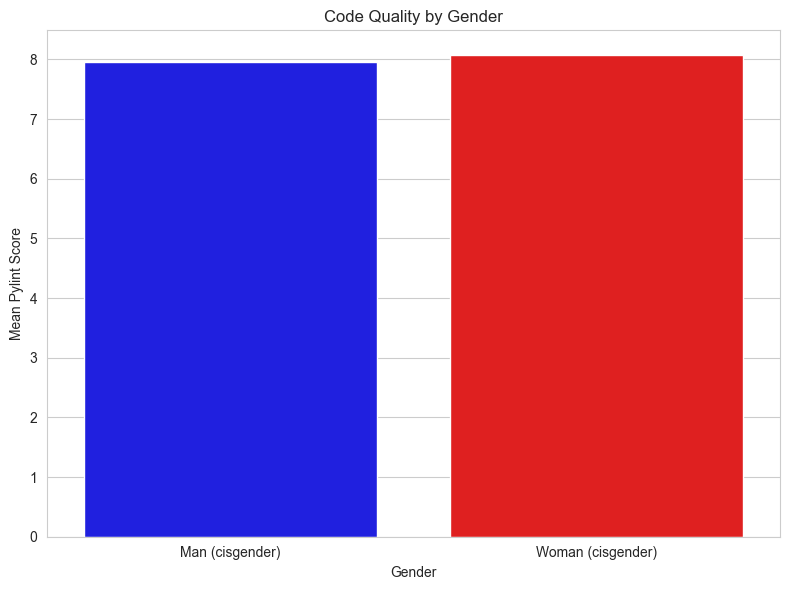

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/3178528713.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


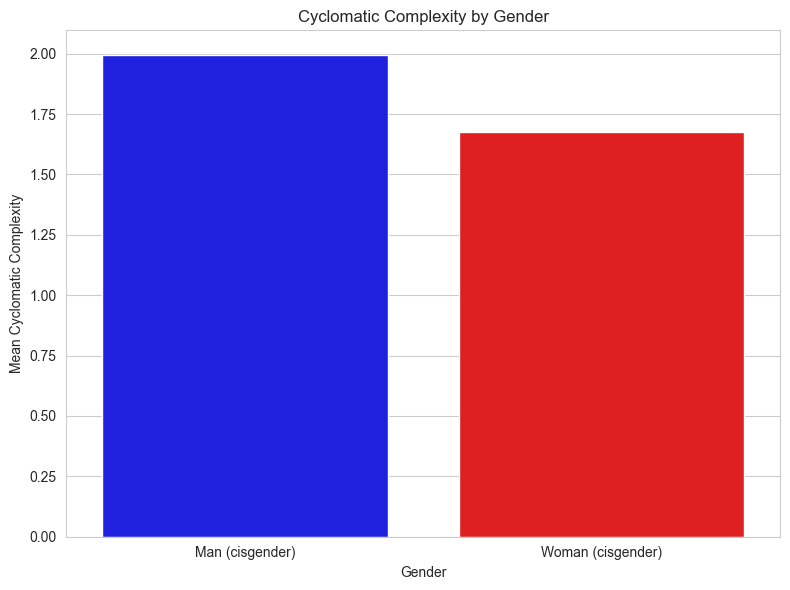

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/3178528713.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


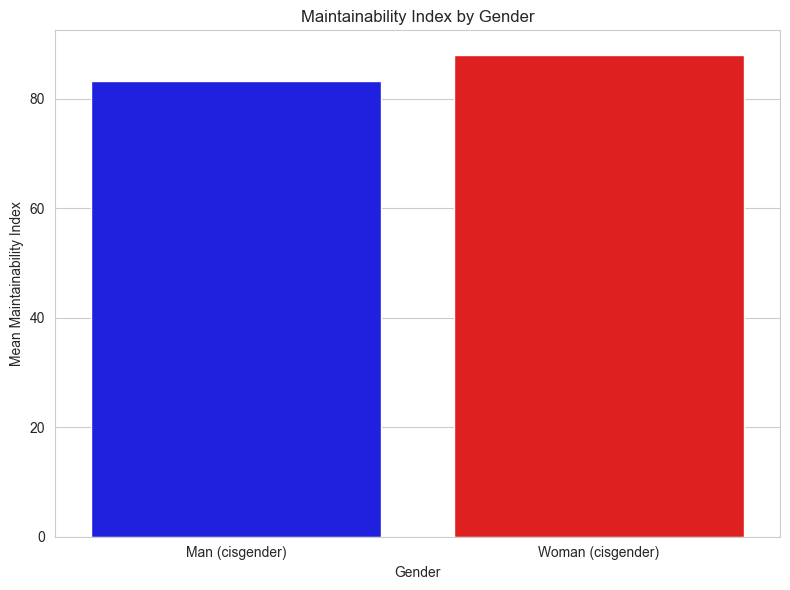

Man (cisgender): 98
Woman (cisgender): 138


In [27]:
import matplotlib.pyplot as plt
import seaborn as sns


# ---- 1. Pylint Score ----

user_avg = (
    code_blocks.groupby(['user_id', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

plot_df = (
    user_avg.groupby(['gender'])['pylint_score']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df,
    x='gender',
    y='pylint_score',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Pylint Score')
plt.title('Code Quality by Gender')
plt.tight_layout()
plt.show()

# ---- 2. Radon Cyclomatic Complexity ----

user_avg_complexity = (
    code_blocks.groupby(['user_id', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plot_df_complexity = (
    user_avg_complexity.groupby(['gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_complexity,
    x='gender',
    y='radon_complexity',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Cyclomatic Complexity')
plt.title('Cyclomatic Complexity by Gender')
plt.tight_layout()
plt.show()

# ---- 3. Radon Maintainability Index ----

user_avg_mi = (
    code_blocks.groupby(['user_id', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plot_df_mi = (
    user_avg_mi.groupby(['gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_mi,
    x='gender',
    y='radon_maintainability_index',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Maintainability Index')
plt.title('Maintainability Index by Gender')
plt.tight_layout()
plt.show()

# ---- Optional: Distribution summary ----
summary = code_blocks.groupby(['gender']).size()
for gender, count in summary.items():
    print(f"{gender}: {count}")

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/833142090.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


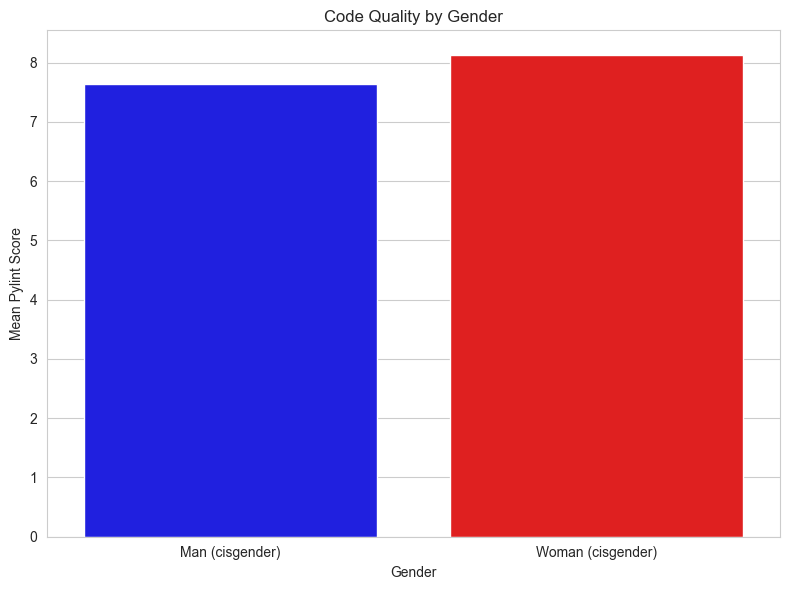

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/833142090.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


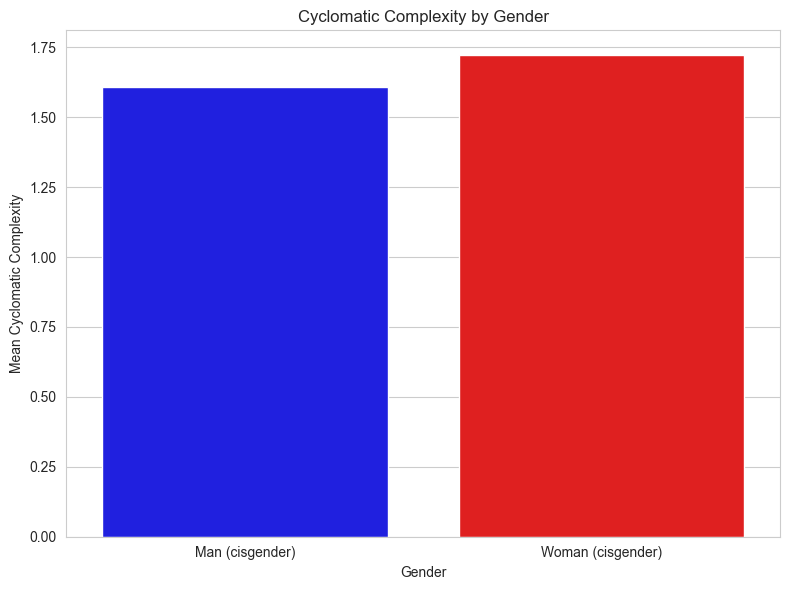

/var/folders/w6/f5trsq6n2jx87f1mqgd_4vv80000gn/T/ipykernel_2335/833142090.py:80: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


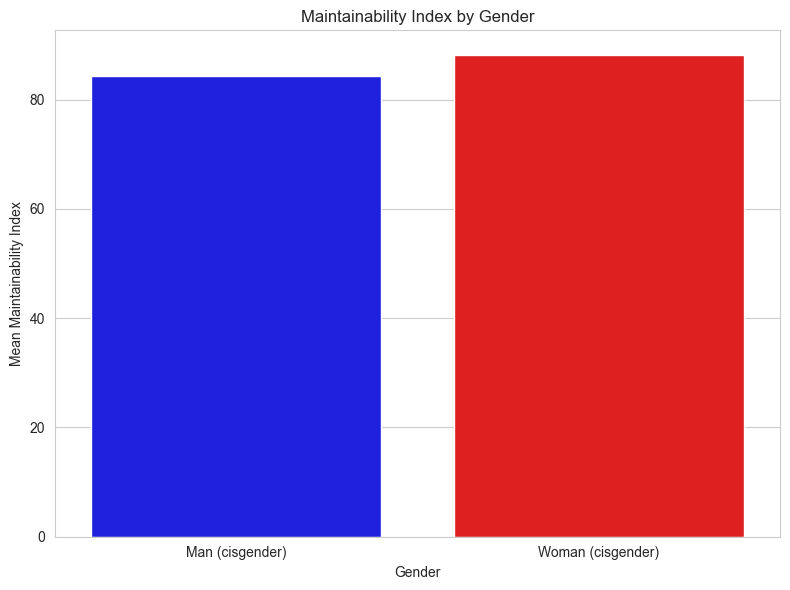

Man (cisgender): 37
Woman (cisgender): 107
                Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    pylint_score
No. Observations:      141        Method:                REML        
No. Groups:            13         Scale:                 3.7390      
Min. group size:       1          Log-Likelihood:        -297.7450   
Max. group size:       34         Converged:             Yes         
Mean group size:       10.8                                          
---------------------------------------------------------------------
                            Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------------
Intercept                   7.419    0.499 14.866 0.000  6.440  8.397
gender[T.Woman (cisgender)] 0.701    0.610  1.149 0.251 -0.495  1.897
Group Var                   0.589    0.227                           



In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf


df_gpt4o = code_blocks[code_blocks['llm_version_normalized'] == "GPT-4o (all)"].reset_index()

# ---- 1. Pylint Score ----

user_avg = (
    df_gpt4o.groupby(['user_id', 'gender'])['pylint_score']
    .mean()
    .reset_index()
)

plot_df = (
    user_avg.groupby(['gender'])['pylint_score']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df,
    x='gender',
    y='pylint_score',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Pylint Score')
plt.title('Code Quality by Gender')
plt.tight_layout()
plt.show()

# ---- 2. Radon Cyclomatic Complexity ----

user_avg_complexity = (
    df_gpt4o.groupby(['user_id', 'gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plot_df_complexity = (
    user_avg_complexity.groupby(['gender'])['radon_complexity']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_complexity,
    x='gender',
    y='radon_complexity',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Cyclomatic Complexity')
plt.title('Cyclomatic Complexity by Gender')
plt.tight_layout()
plt.show()

# ---- 3. Radon Maintainability Index ----

user_avg_mi = (
    df_gpt4o.groupby(['user_id', 'gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plot_df_mi = (
    user_avg_mi.groupby(['gender'])['radon_maintainability_index']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=plot_df_mi,
    x='gender',
    y='radon_maintainability_index',
    palette={'Woman (cisgender)':'red', 'Man (cisgender)':'blue'}
)
plt.xlabel('Gender')
plt.ylabel('Mean Maintainability Index')
plt.title('Maintainability Index by Gender')
plt.tight_layout()
plt.show()

# ---- Optional: Distribution summary ----
summary = df_gpt4o.groupby(['gender']).size()
for gender, count in summary.items():
    print(f"{gender}: {count}")


df_tmp = df_gpt4o.dropna(subset=["pylint_score", "gender", "user_id"])

model = smf.mixedlm("pylint_score ~ gender", data=df_tmp, groups=df_tmp["user_id"])
result = model.fit()
print(result.summary())
